In [270]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OrdinalEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.metrics import accuracy_score,confusion_matrix

In [170]:
df = pd.read_csv("F:\dataset_for_ML\supervised\chatGptGenerated\synthetic_classification_dataset.csv")

In [171]:
df.head()

,Age,Income,Education,Gender,Married,LoanAmount,Approved
0,39.0,51964.122914,High School,Male,No,15419.404257,1
1,33.0,48717.835422,Bachelor,Female,Yes,10546.661414,1
2,41.0,69035.815120,High School,Male,Yes,10820.259366,0
3,50.0,80656.622829,Master,Male,No,15669.075613,0
4,32.0,63736.938883,High School,Other,Yes,10775.234705,1


In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51000 entries, 0 to 50999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         48456 non-null  float64
 1   Income      48453 non-null  float64
 2   Education   51000 non-null  object 
 3   Gender      51000 non-null  object 
 4   Married     51000 non-null  object 
 5   LoanAmount  48442 non-null  float64
 6   Approved    51000 non-null  int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 2.7+ MB


In [173]:
df.duplicated().sum()

1009

In [174]:
df.drop_duplicates(inplace=True)

In [175]:
df.duplicated().sum()

0

In [176]:
df.isna().sum()

Age           2501
Income        2486
Education        0
Gender           0
Married          0
LoanAmount    2486
Approved         0
dtype: int64

In [177]:
df.select_dtypes(["int","float"]).describe()

,Age,Income,LoanAmount,Approved
count,47490.000000,47505.000000,47505.000000,49991.000000
mean,34.496231,50924.853713,15118.574106,0.403033
std,9.993407,29275.128700,5849.097896,0.490512
min,-9.000000,-39259.370542,-7069.429832,0.000000
25%,28.000000,36621.766220,11628.537864,0.000000
50%,35.000000,50133.375764,14986.491841,0.000000
75%,41.000000,63677.115951,18375.040439,1.000000
max,79.000000,888255.728665,133532.596376,1.000000


Age
Income
LoanAmount
Approved


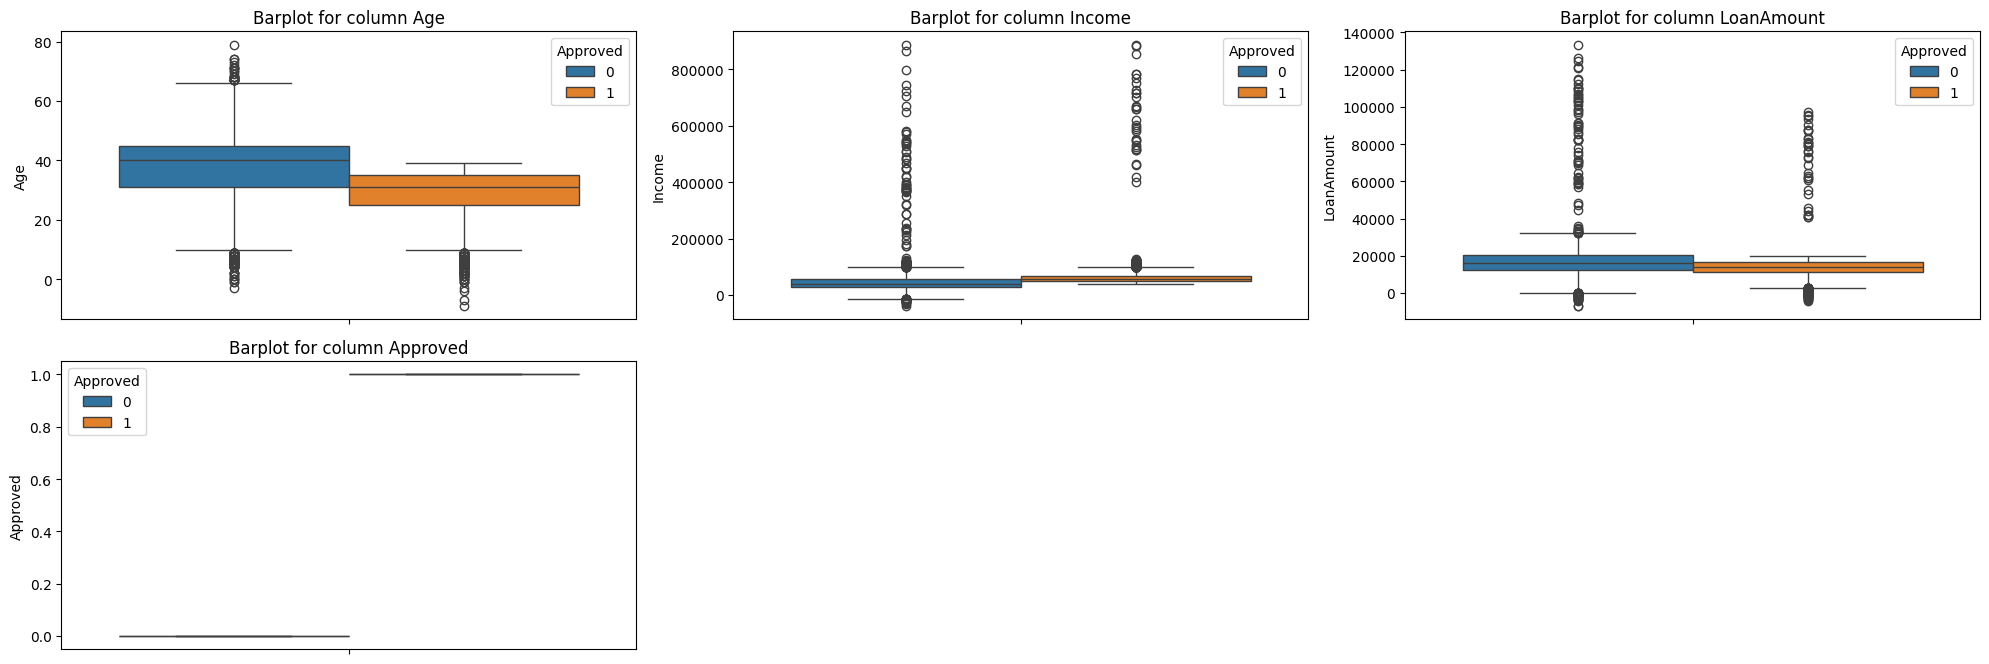

In [178]:
def boxplotFunction(df,for_hue):
    plt.figure(figsize=(20,10))
    for i,column in enumerate(df.columns,1):
        print(column)
        
        plt.subplot(3,3,i)
        sns.boxplot(data=df,y=column,hue=for_hue)
        plt.title(f'Barplot for column {column}')
    plt.tight_layout()
    plt.show()
       


boxplotFunction(df.select_dtypes(["int","float"]),df["Approved"])

Age
Income
LoanAmount
Approved


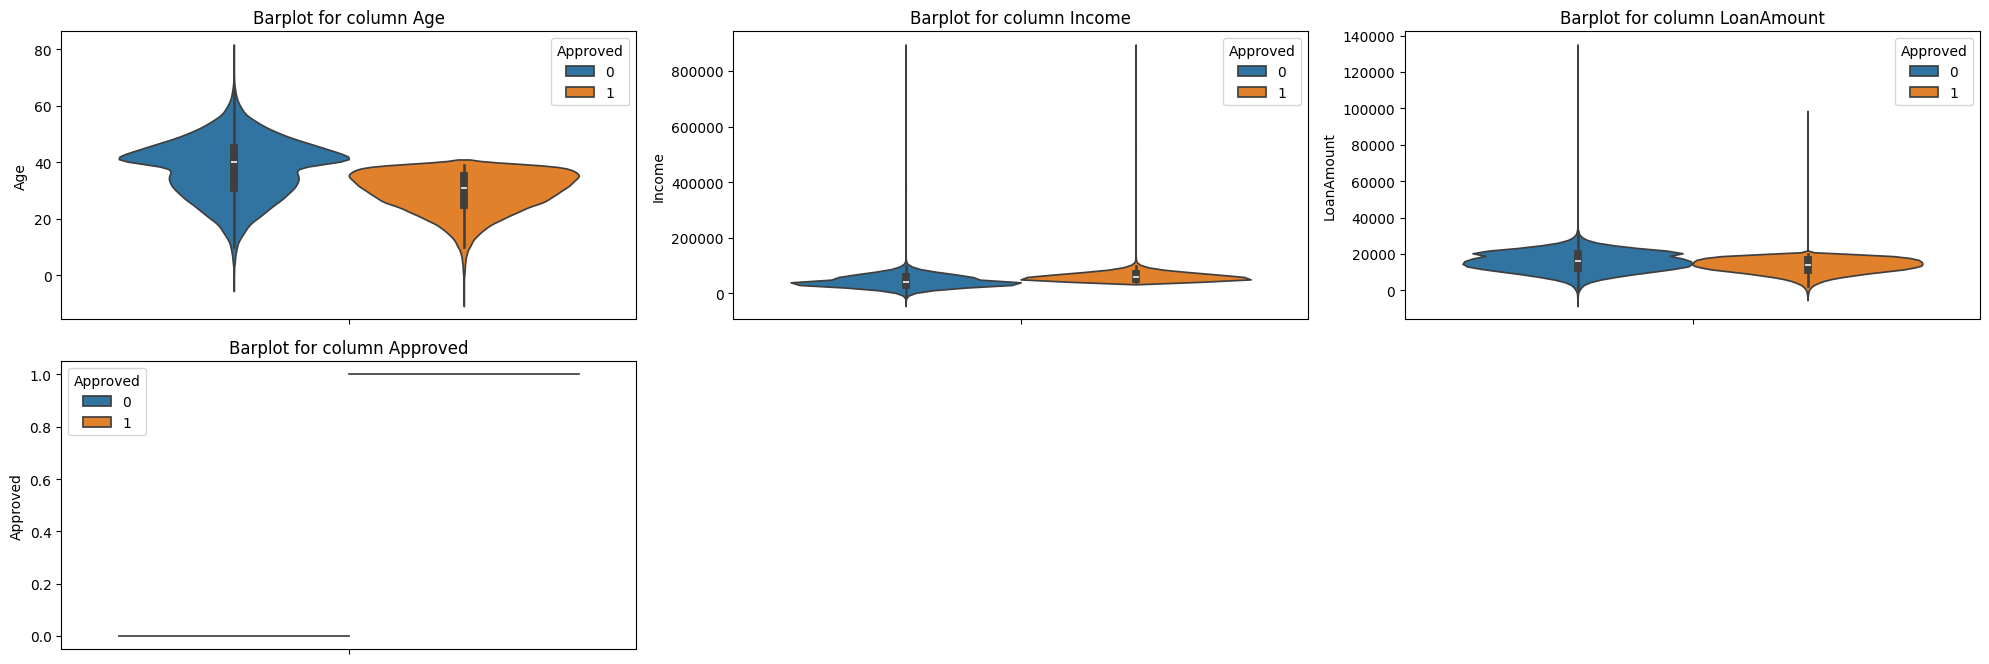

In [179]:
def violinplotFunction(df,for_hue):
    plt.figure(figsize=(20,10))
    for i,column in enumerate(df.columns,1):
        print(column)
        
        plt.subplot(3,3,i)
        sns.violinplot(data=df,y=column,hue=for_hue)
        plt.title(f'Barplot for column {column}')
    plt.tight_layout()
    plt.show()
       


violinplotFunction(df.select_dtypes(["int","float"]),df["Approved"])

Let's use z-index to remove the outliers 

In [180]:
def z_index_calc(df,threshold=3):
    temp_df = df.select_dtypes(["int","float"])
    temp_df = temp_df.iloc[:,:-1]
    for column in temp_df:
        df[column + "_zscore"] = np.abs((temp_df[column]-temp_df[column].mean())/temp_df[column].std())
        
    return df

result = z_index_calc(df)

In [181]:
df

,Age,Income,Education,Gender,Married,LoanAmount,Approved,Age_zscore,Income_zscore,LoanAmount_zscore
0,39.0,51964.122914,High School,Male,No,15419.404257,1,0.450674,0.035500,0.051432
1,33.0,48717.835422,Bachelor,Female,Yes,10546.661414,1,0.149722,0.075389,0.781644
2,41.0,69035.815120,High School,Male,Yes,10820.259366,0,0.650806,0.618647,0.734868
3,50.0,80656.622829,Master,Male,No,15669.075613,0,1.551400,1.015598,0.094117
4,32.0,63736.938883,High School,Other,Yes,10775.234705,1,0.249788,0.437644,0.742566
...,...,...,...,...,...,...,...,...,...,...
50007,20.0,745365.159577,Master,Female,No,126048.482841,0,1.450579,23.721170,18.965302
50185,28.0,506010.277075,High School,Male,Yes,114326.567358,0,0.650052,15.545121,16.961247
50206,38.0,717033.786977,High School,Female,No,95740.761605,1,0.350608,22.753408,13.783696
50495,NaN,450055.862841,PhD,Other,Yes,91420.460833,0,NaN,13.633792,13.045069


In [182]:
df.shape

(49991, 10)

In [183]:
filtered_df = df[((df["Income_zscore"] > -3) & (df["Income_zscore"] < 3)) & ((df["Income_zscore"] > -3) & (df["Age_zscore"] < 3)) & ((df["LoanAmount_zscore"] > -3) & (df["LoanAmount_zscore"] < 3))]

In [184]:
filtered_df.sample(10)

,Age,Income,Education,Gender,Married,LoanAmount,Approved,Age_zscore,Income_zscore,LoanAmount_zscore
34450,48.0,4421.078073,High School,Male,No,9872.616956,0,1.351268,1.588508,0.896883
9331,31.0,15533.345431,Bachelor,Male,No,15134.302795,0,0.349854,1.208928,0.002689
31892,28.0,19711.154828,Bachelor,Female,Yes,12452.207742,0,0.650052,1.066219,0.455859
49702,46.0,64339.993606,PhD,Male,Yes,23843.520121,0,1.151136,0.458244,1.491674
41145,29.0,69294.008906,High School,Female,Yes,11348.194232,1,0.549986,0.627466,0.644609
5202,36.0,49384.135402,Bachelor,Female,No,8851.548058,1,0.150476,0.052629,1.071452
2003,31.0,63392.444544,Bachelor,Male,No,14025.298829,1,0.349854,0.425877,0.186913
24402,51.0,45314.071023,Master,Male,Yes,20143.617378,0,1.651466,0.191657,0.859114
17131,52.0,53335.697225,High School,Male,No,17541.932370,0,1.751532,0.082351,0.414313
20769,29.0,48740.818206,PhD,Male,Yes,9570.233180,1,0.549986,0.074604,0.948581


In [185]:
filtered_df.drop(columns=["Age_zscore","Income_zscore","LoanAmount_zscore"],inplace=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_14744\3451669030.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(columns=["Age_zscore","Income_zscore","LoanAmount_zscore"],inplace=True)


In [186]:
filtered_df.select_dtypes(["int","float"]).describe()

,Age,Income,LoanAmount,Approved
count,42717.000000,42717.000000,42717.000000,42717.000000
mean,34.491584,50049.483510,15003.038175,0.402767
std,9.859095,20072.038717,4974.408592,0.490460
min,5.000000,-33154.677548,-2365.231125,0.000000
25%,28.000000,36527.207940,11633.689372,0.000000
50%,35.000000,50073.478083,14982.088546,0.000000
75%,41.000000,63579.275096,18363.083764,1.000000
max,64.000000,126595.643427,32630.130973,1.000000


Age
Income
LoanAmount
Approved


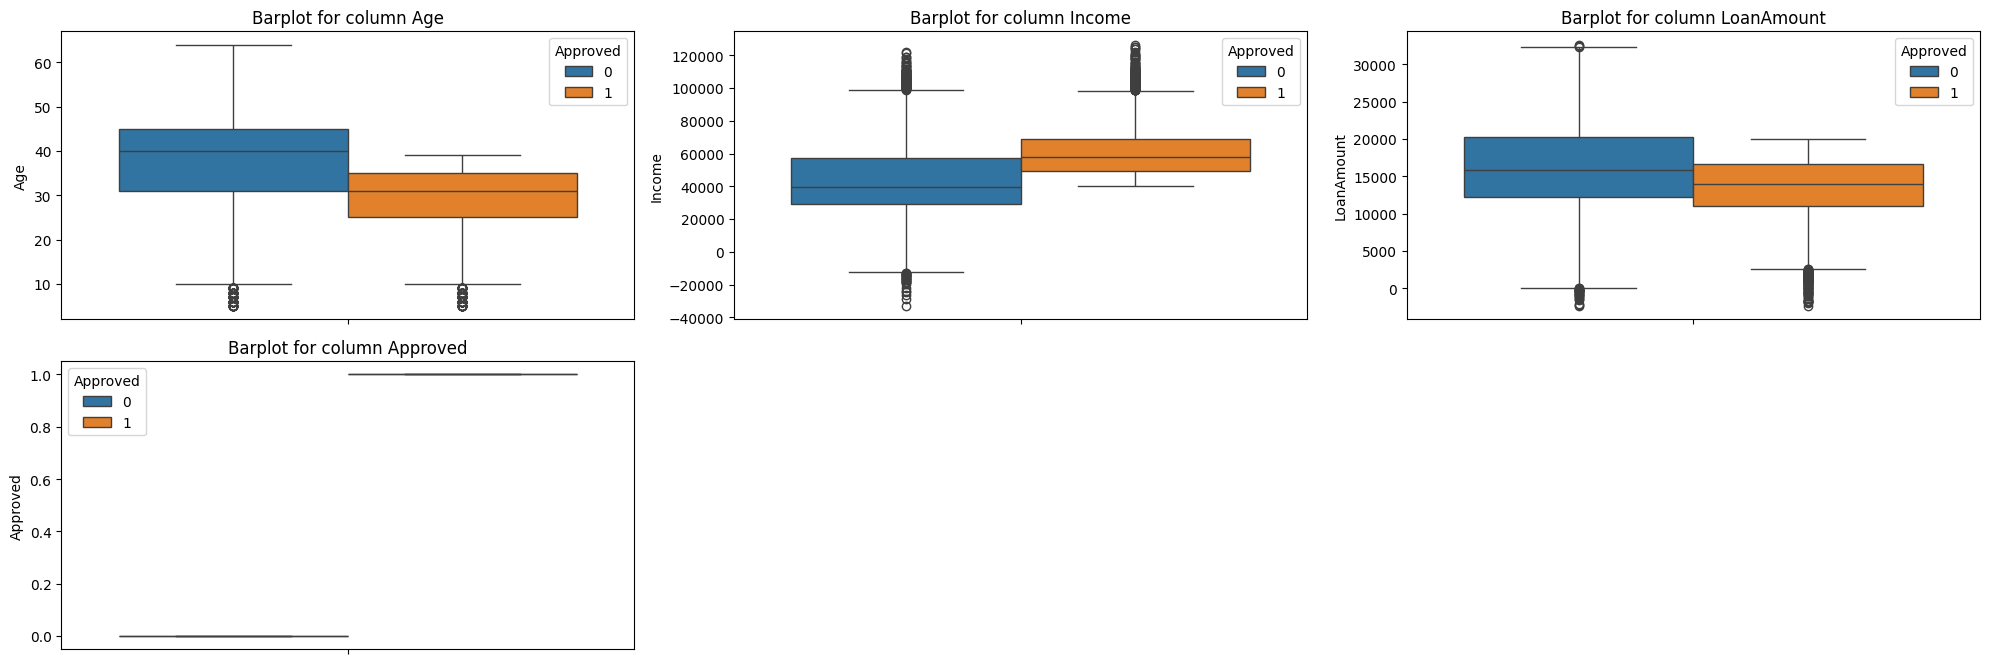

In [187]:
boxplotFunction(filtered_df.select_dtypes(["int","float"]),filtered_df["Approved"])

<Figure size 2000x1000 with 0 Axes>

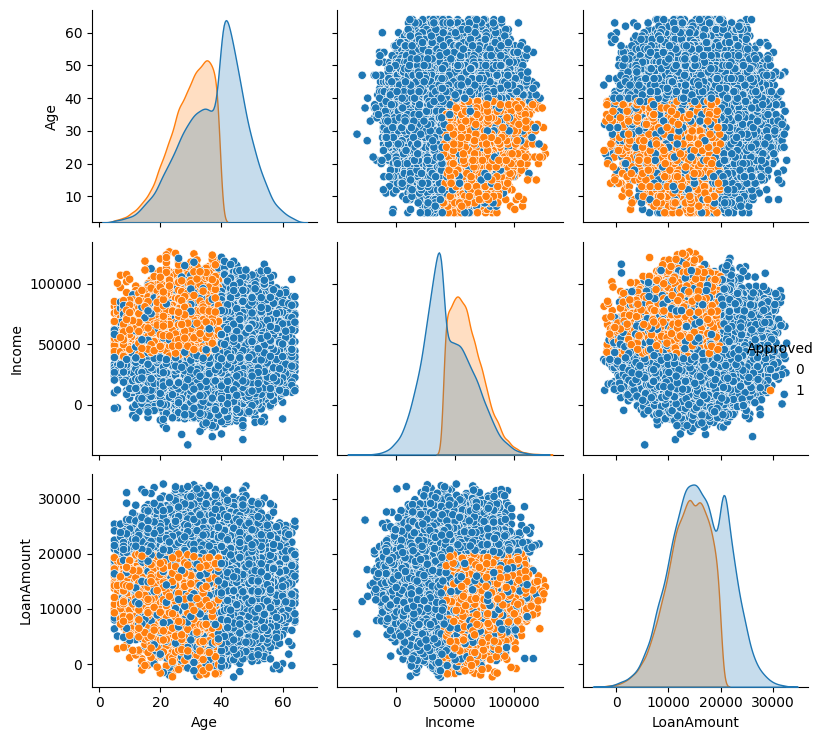

In [188]:
plt.figure(figsize=(20,10))
sns.pairplot(filtered_df.select_dtypes(["int","float"]),diag_kind="kde",hue="Approved")
plt.tight_layout()
plt.show()

In [189]:
filtered_df.isna().sum()

Age           0
Income        0
Education     0
Gender        0
Married       0
LoanAmount    0
Approved      0
dtype: int64

<Axes: >

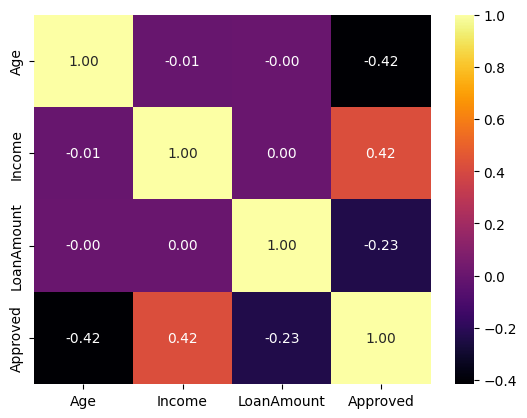

In [190]:
sns.heatmap(filtered_df.select_dtypes(["int","float"]).corr(),cmap="inferno",annot=True,fmt='.2f')

The only good relation we have here is of income and approved ! 

In [191]:
filtered_df.sample(10)

,Age,Income,Education,Gender,Married,LoanAmount,Approved
47409,37.0,49389.591437,Bachelor,Female,Yes,20463.218028,0
17271,38.0,51024.308953,PhD,Male,Yes,22374.191302,0
22285,40.0,39435.048446,High School,Female,Yes,15631.282555,0
41301,35.0,73307.473898,Bachelor,Male,Yes,17246.727644,1
34704,28.0,37127.583298,Bachelor,Other,No,13762.801506,0
25026,38.0,27175.062323,Bachelor,Male,No,15301.429213,0
26315,56.0,96068.990237,High School,Male,Yes,22067.223866,0
24394,39.0,51614.091704,Bachelor,Other,Yes,17014.460342,1
10993,30.0,48773.580095,High School,Female,No,25122.281988,0
33397,24.0,30462.892686,Bachelor,Male,Yes,25730.970180,0


In [236]:
filtered_df["Education"].value_counts()

Education
Bachelor       17214
High School    12575
Master          8571
PhD             4357
Name: count, dtype: int64

Simply, Let's break it down ! 
1) Since, there are no null values, we do not have to fill the null values. 
2) we will definitely normalize the Age,Income and loan amount 
3) We will than encode the categorical columns. Gender, married --> One Hot Encoding and Education --> Ordinal Encoding ! 
4) But before that we will train_test split the data ! 
5) Also we will use both MinMaxScaler and Normal Scaler to check the accuracy ! , which is better ? and probably different algorithms too ! lets gooooooooooooooooooooooooo! 

In [237]:
num_cols = ["Age","Income","LoanAmount"]
ordinal_cols = ["Education"]
education_level = [["High School","Bachelor","Master","PhD"]]
one_hot_cols = ["Gender","Married"]

In [238]:
one_hot_cols

['Gender', 'Married']

In [239]:
num_pipeline_standard_scaler = Pipeline(steps=[
    ("standard Scaling",StandardScaler())
])

In [240]:
num_pipeline_minmax_scaler = Pipeline(
    steps=[
        ("Min Max Scaling",MinMaxScaler())
    ]
)

In [241]:
one_hot_pipeline = Pipeline(
    steps=[
        ("One Hot Encoding",OneHotEncoder(handle_unknown="ignore",sparse_output=False,drop="first"))
    ]
)

In [242]:
ordinal_pipeline = Pipeline(
    steps = [
        ("Ordinal Encoding" , OrdinalEncoder(categories=education_level))
    ]
)

In [243]:
preprocessing_standard_scaler = ColumnTransformer(
    transformers=[
        ("standard_scaler",num_pipeline_standard_scaler,num_cols),
        ("one_hot",one_hot_pipeline,one_hot_cols),
        ("ordinal_encoding",ordinal_pipeline,ordinal_cols)
    ],
    remainder="passthrough",
    n_jobs = -1 
)

In [244]:
standard_pipeline  = Pipeline(
    [
        ("preprocessing_standard",preprocessing_standard_scaler),
        ("logisticRegression",LogisticRegression())
    ]
)

In [245]:
standard_pipeline

Pipeline(steps=[('preprocessing_standard',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('standard_scaler',
                                                  Pipeline(steps=[('standard '
                                                                   'Scaling',
                                                                   StandardScaler())]),
                                                  ['Age', 'Income',
                                                   'LoanAmount']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('One Hot '
                                                                   'Encoding',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender', 'Married']),
                                                 ('ordinal_encoding',
                                                  Pipeline(steps=[('Ordinal '
                                                                   'Encoding',
                                                                   OrdinalEncoder(categories=[['High '
                                                                                               'School',
                                                                                               'Bachelor',
                                                                                               'Master',
                                                                                               'PhD']]))]),
                                                  ['Education'])])),
                ('logisticRegression', LogisticRegression())])

In [246]:
X = filtered_df.iloc[:,:-1]
y = filtered_df["Approved"]

In [247]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [248]:
standard_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessing_standard',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('standard_scaler',
                                                  Pipeline(steps=[('standard '
                                                                   'Scaling',
                                                                   StandardScaler())]),
                                                  ['Age', 'Income',
                                                   'LoanAmount']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('One Hot '
                                                                   'Encoding',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender', 'Married']),
                                                 ('ordinal_encoding',
                                                  Pipeline(steps=[('Ordinal '
                                                                   'Encoding',
                                                                   OrdinalEncoder(categories=[['High '
                                                                                               'School',
                                                                                               'Bachelor',
                                                                                               'Master',
                                                                                               'PhD']]))]),
                                                  ['Education'])])),
                ('logisticRegression', LogisticRegression())])

In [249]:
standard_pipeline.score(X_train,y_train)

0.7987299915137682

In [250]:
standard_pipeline.score(X_test,y_test)

0.7993913857677902

In [251]:
standard_ppe_pred = standard_pipeline.predict(X_test)

In [255]:
accuracy_score(standard_ppe_pred,y_test)

0.7993913857677902

<Axes: >

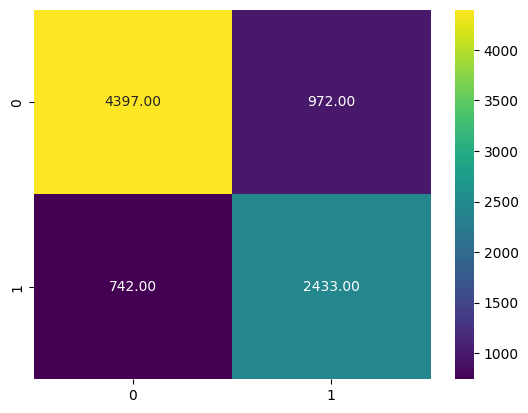

In [259]:
sns.heatmap(confusion_matrix(standard_ppe_pred,y_test),cmap="viridis",fmt='.2f',annot=True)

Using minmax scaler 

In [260]:
preprocessing_minmax = ColumnTransformer(
    transformers=[
        ("minmax scaling",num_pipeline_minmax_scaler,num_cols),
        ("one_hot",one_hot_pipeline,one_hot_cols),
        ("ordinal_encoding",ordinal_pipeline,ordinal_cols)
    ],
    remainder="passthrough",
    n_jobs=-1
)

In [261]:
pipelining_minmax = Pipeline([
    ("Preprocessing_minmax",preprocessing_minmax),
    ("logisticRegression",LogisticRegression())
])

In [262]:
pipelining_minmax.fit(X_train,y_train)

Pipeline(steps=[('Preprocessing_minmax',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('minmax scaling',
                                                  Pipeline(steps=[('Min Max '
                                                                   'Scaling',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Income',
                                                   'LoanAmount']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('One Hot '
                                                                   'Encoding',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender', 'Married']),
                                                 ('ordinal_encoding',
                                                  Pipeline(steps=[('Ordinal '
                                                                   'Encoding',
                                                                   OrdinalEncoder(categories=[['High '
                                                                                               'School',
                                                                                               'Bachelor',
                                                                                               'Master',
                                                                                               'PhD']]))]),
                                                  ['Education'])])),
                ('logisticRegression', LogisticRegression())])

In [263]:
pipelining_minmax.score(X_train,y_train),pipelining_minmax.score(X_test,y_test)

(0.7984080999619583, 0.7993913857677902)

In [267]:
pipelining_ppe_pred_minmax = pipelining_minmax.predict(X_test)

In [268]:
accuracy_score(pipelining_ppe_pred_minmax,y_test)

0.7993913857677902

<Axes: >

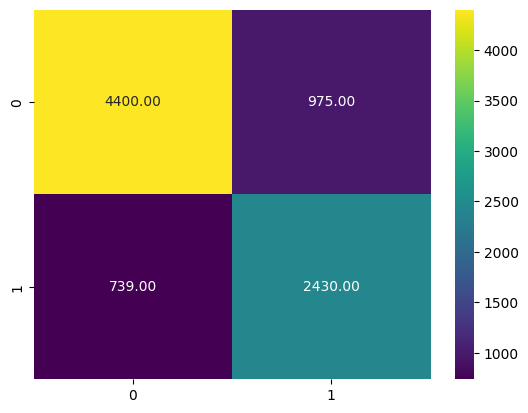

In [272]:
sns.heatmap(confusion_matrix(pipelining_ppe_pred_minmax,y_test),cmap="viridis",fmt='.2f',annot=True)

In [273]:
joblib.dump(standard_pipeline,"standardPipeline.pkl")
joblib.dump(pipelining_minmax,"minmaxpipelining.pkl")

['minmaxpipelining.pkl']

We will use different algo here, but first let me take a bit of break here 